# CorNN scheme run demo

* [1. Insetion algorithm (fingerprint embedding)](#insertion)
    * [Step 1](#i-step-1) - an example of mark=0
    * [Step 2](#i-step-2) - an example of mark=1
    * [Step 3](#i-step-3) - an example of marking an attribute with missing values
    * ...
* [2. Detection algorithm](#detection)
    * [Step 1](#d-step-1)
    * [Step 2](#d-step-2)
    * [Step 3](#d-step-3)
    * [Step 50 to end](#d-step-50)

In [1]:
import pandas as pd
from pprint import pprint
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image

In [2]:
from NCorrFP_scheme.NCorrFP import NCorrFP, sample_from_area

In [3]:
# original data
data = "NCorrFP_scheme/test/test_data/synthetic_40_3_continuous.csv"
dataset = pd.read_csv(data)
correlated_attributes = ['X', 'Y']
dataset.head(20)

,Id,X,Y,Z
0,0,59,37,31
1,1,49,36,20
2,2,56,47,35
3,3,64,43,26
4,4,40,29,27
5,5,44,31,35
6,6,63,51,28
7,7,63,42,26
8,8,47,29,23
9,9,47,41,25


In [4]:
# fingerprinting 
scheme = NCorrFP(gamma=1, fingerprint_bit_length=8, k=10)
fingerprinted_data, iter_log = scheme.demo_insertion(data, primary_key_name='Id', secret_key=101, recipient_id=4,
                                              correlated_attributes=correlated_attributes)

Start the demo NCorr fingerprint insertion algorithm...
	gamma: 1
	correlated attributes: ['X', 'Y']

Generated fingerprint for recipient 4: 01011100

Generated fingerprint for recipient 4: 01011100
Inserting the fingerprint...

Training balltrees in: 0.01 sec.
Fingerprint inserted.
Runtime: 0 ms.


## 1. Insertion algorithm (embedding) <a class="anchor" id="insertion"></a>
The insertion algorithm takes as input:
- dataset
- owner's secret key, recipient ID
- fingerprint length, marking ratio gamma
- list of correlated attributes
- whether the neighbourhood search is distance based (_d_ -- max distance) or cardinality based (_k_ -- minimum cardinality of the neighbourhood)

### Step 1: <a class="anchor" id="i-step-1"></a>
The marking position  (row, attribute) are chosen pseudorandomly seeded by the owner's secret key
#### Marking position: 
- Marking row: 0
- Marking attribute: "_deg-malig_"
- Original value: 3

In [20]:
print("Marking record no. " + str(iter_log[0]['row_index'])) # --> 0
print("Marking attribute: " + str(iter_log[0]['attribute'])) # --> Y
dataset.iloc[[0]]

Marking record no. 0
Marking attribute: Y


,Id,X,Y,Z
0,0,59,37,31


#### Neighbourhood: 
We are looking now in the neighbourhood of the attribute X correlated to Y, the one we are marking. Now the neighbourhood should be the records where X is the closest to 59. 

In [7]:
print('Neighbours idx: ' + str(iter_log[0]['neighbors']))
print('Neighbours dist: ' + str(iter_log[0]['dist']))
print('Neighbours values:' + str(list(dataset.iloc[iter_log[0]['neighbors']]['X'])))

Neighbours idx: [0, 25, 2, 20, 6, 7, 3, 36, 17, 32]
Neighbours dist: [0.0, 1.0, 3.0, 3.0, 4.0, 4.0, 5.0, 6.0, 7.0, 9.0]
Neighbours values:[59, 58, 56, 62, 63, 63, 64, 53, 52, 50]


To sum up:
- Correlated attributes: _X, Y_
- Neighbourhood size: 10
- Max distance (hamming): 9

Now we look into values of Y, the attribute we are marking, in the neighbourhood, to decide on a new one.

In [16]:
print('Target values:' + str(list(dataset.iloc[iter_log[0]['neighbors']]['Y'])))

Target values:[37, 38, 47, 38, 51, 42, 43, 36, 39, 35]


Let's plot the distribution of the X variable in the neighbourhood.
The mark bit is 0, so we will be sampling the new value from less dense areas.

In [9]:
mark_bit = iter_log[0]['mark_bit']
print(mark_bit)

0


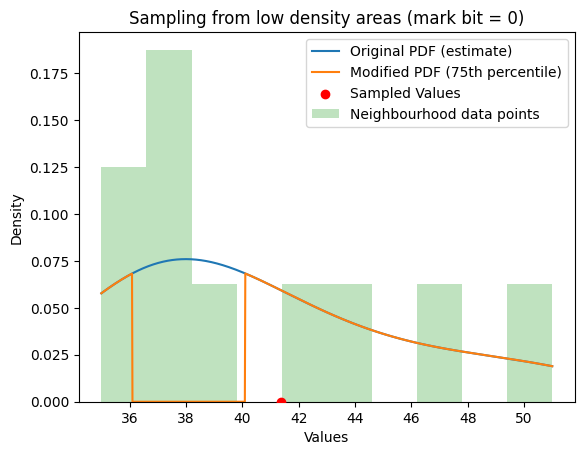

array([41.36127574])

In [17]:
sample_from_area(data=list(dataset.iloc[iter_log[0]['neighbors']]['Y']), percent=0.75, dense=mark_bit, plot=True, 
                 seed=iter_log[0]['seed'])

In [18]:
iter_log[0]['new_value']

42

#### Marking:

The goal is to modify its value to something that is _likely_ to occur. To introduce pseudorandomness, we obtain _mark bit_ from PRNG based on which there are two outcomes:
- _mark bit is 1_ (50%) -- the new value is sampled from the most dense areas of a distribution of the target variable in the neighbourhood
- _mark bit is 0_ (50%) -- the new value is sampled from the tails of distribution of the target value in the neighbourhood

We used Gaussian Kernel estimaton method to estimate the distribution of the values in the neighbourhood. Once we do that, we cut of the 75th percentile and sample from the tails of the distribution since the mark bit was 0.
If the mark bit was 1, we would have sampled from the dense areas of the distribution (we will see that in the following iterations).
The sampled value is rounded to the closest existing from the neighbourhood (to avoid perceptibility of marks in the fingerprinted data).
The final chosen value for attribute Y of record 0 is 42.

In [19]:
fingerprinted_data.head(1)

,Id,X,Y,Z
0,0,59,42,31


### Step 2: <a class="anchor" id="i-step-2"></a>
#### Marking position: 
- Marking row 0, attribute "_age_"

In [21]:
print("Marking record no. " + str(iter_log[1]['row_index'])) # --> 0
print("Marking attribute: " + str(iter_log[1]['attribute'])) # --> Y
dataset.iloc[[1]]

Marking record no. 1
Marking attribute: Z


,Id,X,Y,Z
1,1,49,36,20


Attribute Z is not correlated to the others, so we will use all other attributes to find the closest neighbours and choose a new value, to still preseve the integrity of the dataset.

In [22]:
print('Neighbours idx: ' + str(iter_log[1]['neighbors']))
print('Neighbours dist: ' + str(iter_log[1]['dist']))
print('Neighbours values:' + str(list(dataset.iloc[iter_log[1]['neighbors']]['X'])))

Neighbours idx: [36, 12, 24, 26, 15, 39, 6, 7, 8, 9, 10, 11, 0, 13, 14, 2, 16, 17, 18, 19, 20, 21, 22, 23, 3, 25, 4, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 5]
Neighbours dist: [0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Neighbours values:[53, 49, 49, 38, 49, 42, 63, 63, 47, 47, 47, 43, 59, 34, 38, 56, 36, 52, 43, 41, 62, 47, 45, 30, 64, 58, 40, 59, 46, 44, 46, 76, 50, 47, 45, 42, 29, 37, 44]


Neighbourhood is larger than k=10 because there were multiple neighbours of distance=1.0 so we take them all into account.
The neighbourhood looks as follows:

In [14]:
dataset.iloc[iter_log[1]['neighbors']]

,Id,X,Y,Z
36,36,53,36,35
12,12,49,33,21
24,24,49,30,24
26,26,38,36,13
15,15,49,24,30
39,39,42,40,29
6,6,63,51,28
7,7,63,42,26
8,8,47,29,23
9,9,47,41,25


In [23]:
print('Target values:' + str(list(dataset.iloc[iter_log[1]['neighbors']]['Z'])))

Target values:[35, 21, 24, 13, 30, 29, 28, 26, 23, 25, 15, 23, 31, 18, 12, 35, 16, 25, 25, 12, 33, 30, 17, 19, 26, 29, 27, 20, 25, 25, 23, 36, 22, 21, 31, 15, 18, 12, 35]


In [25]:
mark_bit = iter_log[0]['mark_bit']
print('Mark bit is {}, therefore we sample from tails of distribution of the variable Z in the neighbourhood.'.format(mark_bit))

Mark bit is 0, therefore we sample from tails of distribution of the variable Z in the neighbourhood.


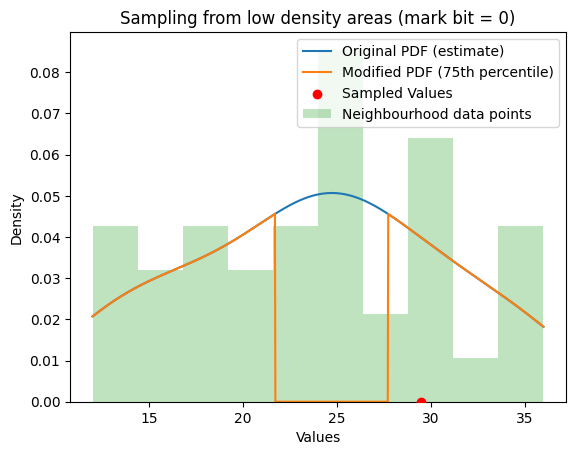

array([29.46914676])

In [28]:
sample_from_area(data=list(dataset.iloc[iter_log[1]['neighbors']]['Z']), percent=0.75, dense=mark_bit, plot=True, 
                 seed=iter_log[1]['seed'])

In [30]:
iter_log[1]['new_value']

29

In [31]:
fingerprinted_data.iloc[[1]]

,Id,X,Y,Z
1,1,49,36,29


### Step 3: <a class="anchor" id="i-step-3"></a>
#### Marking position: 
- Marking row 2, attribute "Z"

In [43]:
print("Marking record no. " + str(iter_log[2]['row_index'])) # --> 0
print("Marking attribute: " + str(iter_log[2]['attribute'])) # --> Y
dataset.iloc[[2]]

Marking record no. 2
Marking attribute: Z


,Id,X,Y,Z
2,2,56,47,35


#### Neighbourhood: 
- Correlated attributes: X, Y  (we are marking Z, so checking all attributes to define the neighbourhood)
- Neighbourhood size: 1.0
- Max distance (hamming): 0

In [45]:
print('Neighbours idx: ' + str(iter_log[1]['neighbors']))
print('Neighbours dist: ' + str(iter_log[1]['dist']))

Neighbours idx: [36, 12, 24, 26, 15, 39, 6, 7, 8, 9, 10, 11, 0, 13, 14, 2, 16, 17, 18, 19, 20, 21, 22, 23, 3, 25, 4, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 5]
Neighbours dist: [0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [42]:
print('Target values:' + str(list(dataset.iloc[iter_log[2]['neighbors']]['Z'])))

Target values:[29, 20, 31, 26, 27, 35, 28, 26, 23, 25, 15, 23, 21, 18, 12, 30, 16, 25, 25, 12, 33, 30, 17, 19, 24, 29, 13, 20, 25, 25, 23, 36, 22, 21, 31, 15, 18, 12, 35]


In [41]:
mark_bit = iter_log[2]['mark_bit']
print('Mark bit is {}, therefore we sample from tails of distribution of the variable Z in the neighbourhood.'.format(mark_bit))

Mark bit is 0, therefore we sample from tails of distribution of the variable Z in the neighbourhood.


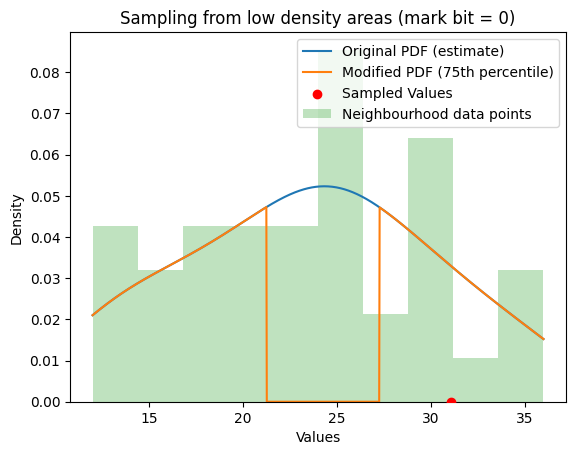

array([31.05851302])

In [46]:
sample_from_area(data=list(dataset.iloc[iter_log[2]['neighbors']]['Z']), percent=0.75, dense=mark_bit, plot=True, 
                 seed=iter_log[2]['seed'])

In [65]:
print(iter_log[2]['new_value'])
fingerprinted_data.iloc[[2]]

31


,Id,X,Y,Z
2,2,56,47,31


### Step 4: <a class="anchor" id="i-step-3"></a>

In [57]:
iter = 3

In [53]:
print("Marking record no. " + str(iter_log[iter]['row_index'])) # --> 3
print("Marking attribute: " + str(iter_log[iter]['attribute'])) # --> X
dataset.iloc[[iter]]

Marking record no. 3
Marking attribute: X


,Id,X,Y,Z
3,3,64,43,26


In [58]:
print('Neighbours idx: ' + str(iter_log[iter]['neighbors']))
print('Neighbours dist: ' + str(iter_log[iter]['dist']))

Neighbours idx: [7, 9, 39, 33, 34, 2, 17, 27, 31, 20, 25]
Neighbours dist: [1.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0]


In [56]:
print('Target values:' + str(list(dataset.iloc[iter_log[iter]['neighbors']][iter_log[iter]['attribute']])))

Target values:[63, 47, 42, 47, 45, 56, 52, 59, 76, 62, 58]


In [61]:
mark_bit = iter_log[iter]['mark_bit']
print('Mark bit is {}, therefore we sample from the dense part of distribution of the variable Z in the neighbourhood.'.format(mark_bit))

Mark bit is 1, therefore we sample from the dense part of distribution of the variable Z in the neighbourhood.


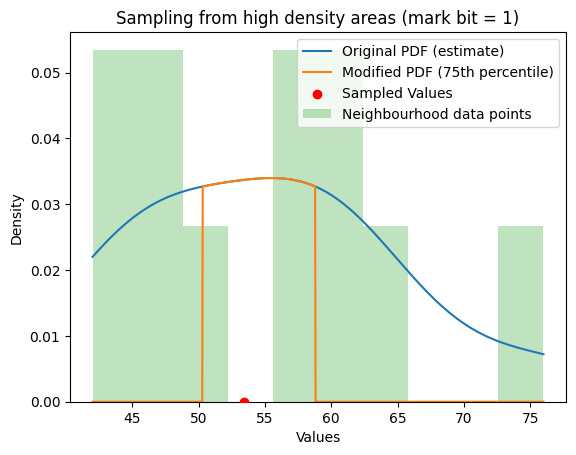

array([53.43511869])

In [63]:
sample_from_area(data=list(dataset.iloc[iter_log[iter]['neighbors']][iter_log[iter]['attribute']]), percent=0.75, 
                 dense=mark_bit, plot=True, seed=iter_log[iter]['seed'])

In [64]:
print(iter_log[iter]['new_value'])
fingerprinted_data.iloc[[iter]]

52


,Id,X,Y,Z
3,3,52,43,26


## 2. Detection Algorithm <a class="anchor" id="detection"></a>
Detection algorithm takes as input the fingerpirnted dataset and following parameters:
- owner's secret key
- gamma (original ratio of marked rows), length of the fingerprint
- a list of marked attribute names
- a list of correlated attributes
- whether the algorithm is distance based (_d_ -- max distance for the neighbourhood) or cardinality based (_k_ -- min cardinality of the neighbourhood)

In [ ]:
fingerprinted_data.head(20)

In [ ]:
# 1st position where the mark -should- be
suspect, det_iter_log = scheme.demo_detection(fingerprinted_data, secret_key=601, primary_key='Id',
                               correlated_attributes=['age', 'menopause', 'inv-nodes', 'node-caps'],
                               original_columns=["age", "menopause", "tumor-size", "inv-nodes", "node-caps",
                                                 "deg-malig", "breast", "breast-quad",
                                                 "irradiat", "recurrence"])

The detected fingerprint is correct and attributed to the correct recipient, hence, the detection was successful. 


The detection reverses the insertion process. This means that each step from detection should match the respective step from the insertion in terms of choosing the same marking row, attribute, and a fingerprint bit. 
Let's inspect the steps:

### Step 1 <a class="anchor" id="d-step-1"></a>
#### Marking position: 
- Marking row: 0
- Marking attribute: "_deg-malig_"
- Value at the position: 1

In [ ]:
# det_iter_log[0]['row_index'] # --> 0
# det_iter_log[0]['attribute'] # --> deg-malig
fingerprinted_data.iloc[[0]]

#### Neighbourhood: 
- Correlated attributes: _age, menopause, inv-nodes, node-caps_
- Neighbourhood size: 19
- Max distance (hamming): 0

In [ ]:
# max(det_iter_log[0]['dist'])
fingerprinted_data.iloc[det_iter_log[0]['neighbors']] 

- Frequencies in the neighbourhood.

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,4))

axs[0].bar(list(det_iter_log[0]['frequencies'].keys()), list(det_iter_log[0]['frequencies'].values()), align='center')
axs[0].set_xticks(list(det_iter_log[0]['frequencies'].keys()))
axs[0].set_ylabel('% in neighbourhood')
axs[0].set_xlabel('value of \'deg-malig\' in the neighbourhood\n (Fingerprinted data)')
axs[0].grid(axis='y')

axs[1].bar(list(iter_log[0]['frequencies'].keys()), list(iter_log[0]['frequencies'].values()), align='center')
axs[1].set_xticks(list(iter_log[0]['frequencies'].keys()))
axs[1].set_xlabel('value of \'deg-malig\' in the neighbourhood\n (Original dataset)')
axs[1].grid(axis='y')

On the left-hand side, we show the neighbourhoods in the fingerprinted data obtained during the detection. On the right-hand side we show the neighbourhoods of the same record from the original data for comparison.

Note that the neihghbourhood for the same record is not the same -- this is because the fingerprint marks disrupt calculating distances from the record in question. If the similar distribution is preserved, the fingerprint marks will be extracted correctly. The detection algorithm makes a decision on the fingerprint mark based on the frequency ranking and not the exact frequency value. However, this might mean that _some_ marks might be detected wrongly:

#### Detecting the mark:
- Mark bit: 1 --> the fingerprinted value is the most represented in the neighbourhood, hence the mark bit must have been 1 according to the insertion algorithm. In this case, this is a detection error. 
- Detected pseudorandomly in this step:
    - Mask bit: 0 (retrieved pseudorandomly in this step)
    - Finterprint bit position (index): 8
- Fingerprint bit value: 1 (mark bit xor mask bit)

In [ ]:
# det_iter_log[0]['mark_bit'] # --> 1
# det_iter_log[0]['mask_bit'] # --> 0
# det_iter_log[0]['fingerprint_idx'] # --> 8
# det_iter_log[0]['fingerprint_bit'] # --> 1

# updating the votes for fingerprint 
Image("NCorrFP_scheme/figures/CorNN-demo-Votes-step1.png")

The detection error is only a vote in a fingerprint template, hence, the algorithm still has a chance to recover if the majority of the votes for position 8 will be correct in upcoming steps (0).

### Step 2 <a class="anchor" id="d-step-2"></a>
#### Marking position: 
- Marking row: 1
- Marking attribute: "_age_"
- Value at the position: 40-49

In [ ]:
det_iter_log[1]['attribute']

In [ ]:
fingerprinted_data.iloc[[1]]

#### Neighbourhood: 
- Correlated attributes: _(age), menopause, inv-nodes, node-caps_
- Neighbourhood size: 85
- Max distance (hamming): 0

In [ ]:
fingerprinted_data.iloc[det_iter_log[1]['neighbors']]

- Frequencies in the neighbourhood:

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,4))

axs[0].bar(list(det_iter_log[1]['frequencies'].keys()), list(det_iter_log[1]['frequencies'].values()), align='center')
axs[0].set_xticks(list(det_iter_log[1]['frequencies'].keys()))
axs[0].set_ylabel('% in neighbourhood')
axs[0].set_xlabel('value of \'age\' in the neighbourhood\n (Fingerprinted data)')
axs[0].grid(axis='y')

axs[1].bar(list(iter_log[1]['frequencies'].keys()), list(iter_log[1]['frequencies'].values()), align='center')
axs[1].set_xticks(list(iter_log[1]['frequencies'].keys()))
axs[1].set_xlabel('value of \'age\' in the neighbourhood\n (Original dataset)')
axs[1].grid(axis='y')

The frequencies this time resemble more closely those in the original data, hence no confusion about the marking bit is made by the detection algorithm: 

#### Detecting the mark:
- Mark bit: 1 --> the fingerprinted value is the most represented in the neighbourhood, hence the mark bit must have been 1
- Detected pseudorandomly in this step:
    - Mask bit: 1 
    - Finterprint bit position (index): 3
- Fingerprint bit value: 0 (mark bit xor mask bit)

In [ ]:
# det_iter_log[1]['mark_bit'] # --> 1
# det_iter_log[1]['mask_bit'] # --> 1
# det_iter_log[1]['fingerprint_idx'] # --> 3
# det_iter_log[1]['fingerprint_bit'] # --> 0

# updating the votes for fingerprint 
Image("NCorrFP_scheme/figures/CorNN-demo-Votes-step2.png")

### Step 3 <a class="anchor" id="d-step-3"></a>
#### Marking position: 
- Marking row: 3
- Marking attribute: "_node-caps_"
- Value at the position: yes

In [ ]:
fingerprinted_data.iloc[[2]]

#### Neighbourhood: 
- Correlated attributes: _age, menopause, inv-nodes, (node-caps)_
- Neighbourhood size: 49
- Max distance (hamming): 0

In [ ]:
fingerprinted_data.iloc[det_iter_log[2]['neighbors']]

- Frequencies in the neighbourhood:

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,4))

axs[0].bar(list(det_iter_log[2]['frequencies'].keys()), list(det_iter_log[2]['frequencies'].values()), align='center')
axs[0].set_xticks(list(det_iter_log[2]['frequencies'].keys()))
axs[0].set_ylabel('% in neighbourhood')
axs[0].set_xlabel('value of \'node-caps\' in the neighbourhood\n (Fingerprinted data)')
axs[0].grid(axis='y')

axs[1].bar(list(iter_log[2]['frequencies'].keys()), list(iter_log[2]['frequencies'].values()), align='center')
axs[1].set_xticks(list(iter_log[2]['frequencies'].keys()))
axs[1].set_xlabel('value of \'node-caps\' in the neighbourhood\n (Original dataset)')
axs[1].grid(axis='y')

The frequencies resemble the original and it again does not affect the fingerprint bit detection.

#### Detecting the mark:
- Mark bit: 0 --> the fingerprinted value is not the most represented in the neighbourhood, hence the mark bit must have been 0
- Detected pseudorandomly in this step:
    - Mask bit: 0
    - Finterprint bit position (index): 14
- Fingerprint bit value: 0 (mark bit xor mask bit)

In [ ]:
# det_iter_log[2]['mask_bit'] # --> 0
# det_iter_log[2]['fingerprint_idx'] # --> 14
# det_iter_log[2]['fingerprint_bit'] # --> 0

# updating the votes for fingerprint 
Image("NCorrFP_scheme/figures/CorNN-demo-Votes-step3.png")

## ...
We jump to steps 50, 100, 200 and the last step to see the status of the fingerprint template and the votes:
## Step 50 <a class="anchor" id="d-step-50"></a>

In [ ]:
# det_iter_log[49]['fingerprint_bit' # --> 0
# [[0, 2], [0, 2], [0, 3], [5, 0], [4, 0], [4, 0], [3, 0], [1, 3], 
# [1, 1], [3, 1], [0, 5], [0, 3], [0, 2], [0, 3], [4, 0], [0, 0]]

# updating the votes for fingerprint 
Image("NCorrFP_scheme/figures/CorNN-demo-Votes-step50.png")

## Step 100

In [ ]:
# det_iter_log[99]['fingerprint_idx'] # --> 5
# [[0, 5], [0, 6], [0, 4], [5, 1], [6, 1], [5, 0], [6, 0], [1, 7], 
# [3, 1], [5, 2], [0, 7], [0, 7], [1, 7], [1, 7], [10, 0], [2, 0]]

# updating the votes for fingerprint 
Image("NCorrFP_scheme/figures/CorNN-demo-Votes-step100.png")

## Step 200

In [ ]:
# det_iter_log[199]['fingerprint_idx'] # --> 2
# [[1, 10], [0, 10], [3, 11], [11, 2], [14, 1], [10, 1], [9, 1], [2, 13], 
#  [9, 2], [9, 3], [1, 12], [2, 17], [2, 10], [1, 14], [15, 1], [3, 0]]


# updating the votes for fingerprint 
Image("NCorrFP_scheme/figures/CorNN-demo-Votes-step200.png")

## The final result of the detection algorithm
With minor errors in voting, the fingerprint bit-string has been recovered succcessfully. Below we see the final bit-wise votes. The corresponding fingerprint is hence [1110000100111100]

In [ ]:
#[[2, 17], [1, 12], [3, 16], [17, 3], [20, 2], [12, 1], [14, 3], [2, 19], 
# [10, 3], [12, 3], [2, 18], [4, 24], [3, 15], [2, 19], [19, 2], [6, 0]]
Image("NCorrFP_scheme/figures/CorNN-demo-Votes-last.png")